# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
#https://docs.python.org/3/
import math
import random
import pickle
import collections
import csv
import time

#https://python-pillow.org/
from PIL import Image

#https://www.tensorflow.org/
import tensorflow as tf
from tensorflow.contrib.layers import flatten

#http://docs.opencv.org/3.0-beta/index.html
import cv2

#http://www.numpy.org/
import numpy as np

#http://matplotlib.org/
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#http://scikit-learn.org/stable/
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#https://pypi.python.org/pypi/tqdm
from tqdm import tqdm

In [2]:
training_file = 'train.p'
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
X_train, y_train = train['features'], train['labels']

testing_file = 'test.p'
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
X_test, y_test = test['features'], test['labels']

In [3]:
n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Training Set Visualization:

  0%|          | 0/100 [00:00<?, ?it/s]

Sample Training Images:


100%|██████████| 100/100 [00:24<00:00,  2.55it/s]


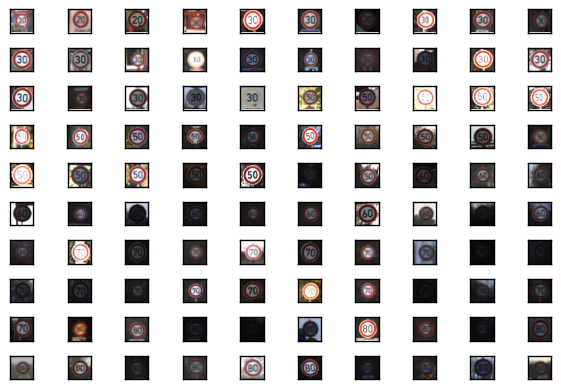

In [4]:
def addsubplot(i, feature):
    plt.subplot(10,10,i)
    plt.xticks(()); plt.yticks(());
    plt.tight_layout()
    plt.imshow(feature)

print('Sample Training Images:')
n = 0
for feature in tqdm(range(0,100)):
    feature = X_train[n*100]
    plt.figure(1)
    addsubplot(n+1, feature)
    n += 1

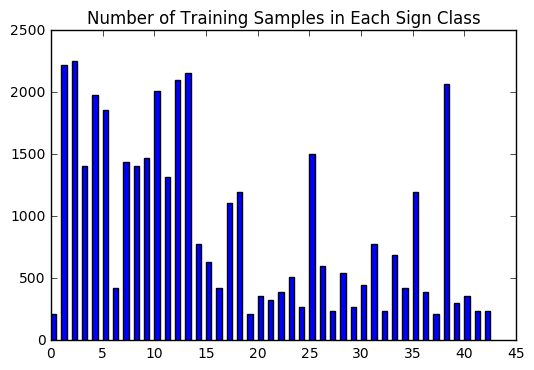

In [5]:
counter = collections.Counter(y_train)
plt.title('Number of Training Samples in Each Sign Class')
labels, values = zip(*counter.items())

indexes = np.arange(len(labels))
width = 0.5
plt.bar(indexes, values, width)
plt.show()

### Testing Set Visualization:

  0%|          | 0/100 [00:00<?, ?it/s]

Sample Testing Images:


100%|██████████| 100/100 [00:24<00:00,  2.47it/s]


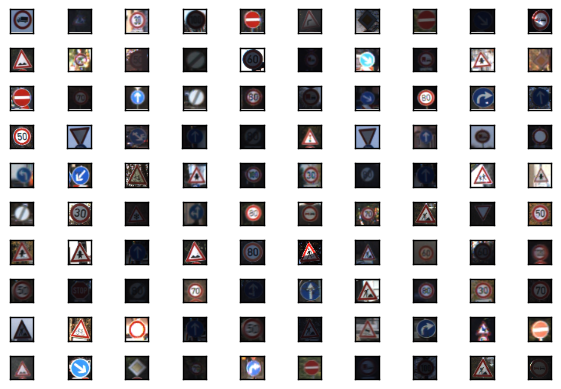

In [6]:
print('Sample Testing Images:')
n = 0
for feature in tqdm(range(0,100)):
    feature = X_test[n*50]
    plt.figure(1)
    addsubplot(n+1, feature)
    n += 1

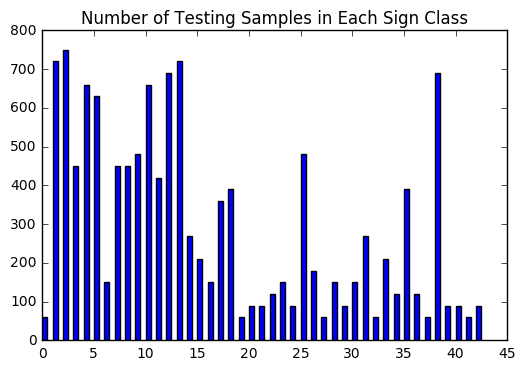

In [7]:
counter = collections.Counter(y_test)
plt.title('Number of Testing Samples in Each Sign Class')
labels, values = zip(*counter.items())

indexes = np.arange(len(labels))
width = 0.5
plt.bar(indexes, values, width)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Pre-processing Training and Testing Features:

In [8]:
def grayscale(image_data):
    return cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)

def normalize(image_data):
    a = 0.1; b = 0.9; MIN = 0; MAX = 255
    return a + (((image_data - MIN)*(b - a))/(MAX - MIN))

def flatten(image_data):
    return image_data.reshape(-1, np.prod(image_data[0].shape))

X_train = flatten(normalize(X_train.astype(np.float32)))
print('Training features pre-processed.')
X_test = flatten(normalize(X_test.astype(np.float32)))
print('Testing features pre-processed.')

Training features pre-processed.
Testing features pre-processed.


### Pre-processing Training and Testing Labels:

In [9]:
def one_hot_encode(label_data):
    encoder = LabelBinarizer()
    encoder.fit(label_data)
    return encoder.transform(label_data)

y_train = one_hot_encode(y_train).astype(np.float32)
print('Training labels pre-processed.')
y_test = one_hot_encode(y_test).astype(np.float32)
print('Testing labels pre-processed.')

Training labels pre-processed.
Testing labels pre-processed.


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

<span style="color: red"> For the features, I ended up normalizing the pickled images from 0.1 to 0.9, flattening them from 32x32x3 to 3072, and converting them to float32 for TensorFlow. I decided against grayscale because I wanted to preserve color in case that helped improve my training accuracy. </span>

<span style="color: red"> For the labels, I one hot encoded the pickled data using the LabelBinarizer from the handy sklearn.preprocessing framework. </span>

In [10]:
print('Training Features to randomize and split: ', len(X_train))

def randomize(features, labels):
    return shuffle(features,
                   labels,
                   random_state=42)

X_train, y_train = randomize(X_train, y_train)
print('Training set randomized.')

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=0)
print('Training and validation sets split.')
print('Training Features: ', len(X_train))
print('Validation Features: ', len(X_valid))

Training Features to randomize and split:  39209
Training set randomized.
Training and validation sets split.
Training Features:  35288
Validation Features:  3921


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:** 

<span style="color: red"> I did not generate additional data, but I read in the forums that it was important to randomize the data since the distribution of the training images is not evenly split. I also went with a 10% test_size for the validation set because it gave me the best performance after trying 10%, 15%, and 20%. </span>

In [11]:
#Helper methods

def neural_network(features, n_features, n_labels):
    
    #Architechture: INPUT --> HIDDEN LAYER 1 --> OUTPUT
    #H1 = Hidden Layer
    #Out = Output Layer
    
    layer_widths = {
        'h1_width': 128  
    }

    weights = {
        'h1': tf.Variable(tf.truncated_normal((n_features, layer_widths['h1_width']), stddev=0.01)),
        'out': tf.Variable(tf.truncated_normal((layer_widths['h1_width'], n_labels), stddev=0.01))}

    biases = {
        'h1': tf.Variable(tf.zeros((layer_widths['h1_width'],))),
        'out': tf.Variable(tf.zeros((n_labels,)), name='b_out')}

    #Perform input layer to hidden layer calculations:
    h1 = tf.add(tf.matmul(features, weights['h1']), biases['h1'])
    h1 = tf.nn.relu(h1)
    
    #Return hidden layer to output layer calculation:
    return tf.add(tf.matmul(h1, weights['out']), biases['out'])

def setup_network():
    n_features = np.prod(X_train[0].shape)
    n_labels = n_classes
    counts = (n_features, n_labels)

    features = tf.placeholder(tf.float32)
    labels = tf.placeholder(tf.float32)
    
    train_feed_dict = {features: X_train, labels: y_train}
    valid_feed_dict = {features: X_valid, labels: y_valid}
    test_feed_dict = {features: X_test, labels: y_test}
    feed_dicts = (train_feed_dict, valid_feed_dict, test_feed_dict)
    
    return (features, labels, counts, feed_dicts)

def plot_loss_accuracy(batches, loss_batch, train_acc_batch, valid_acc_batch):
    loss_plot = plt.subplot(211)
    loss_plot.set_title('Loss')
    loss_plot.plot(batches, loss_batch, 'g')
    loss_plot.set_xlim([batches[0], batches[-1]])
    acc_plot = plt.subplot(212)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
    acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
    acc_plot.set_ylim([0, 1.0])
    acc_plot.set_xlim([batches[0], batches[-1]])
    acc_plot.legend(loc=4)
    plt.tight_layout()
    plt.show() 

In [12]:
#Network setup and variable declarations:
features, labels, counts, feed_dicts = setup_network()
n_features, n_labels = counts
train_feed_dict, valid_feed_dict, test_feed_dict = feed_dicts

#Link the German Traffic Signs features and labels to the network architecture:
logits = neural_network(features, n_features, n_labels)

#Loss calculation:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))

#Accuracy calculation:
is_correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

#Set up the optimizer:
optimizer = tf.train.AdamOptimizer().minimize(loss)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** 

<span style="color: red"> My model is simple, but effective. The architechture follows the design pattern of Aymeric Damien's **MNIST Multilayer Perceptron** example, with the following layers: </span>

<span style="color: red"> INPUT >> HIDDEN LAYER >> OUTPUT </span>

<span style="color: red"> The weight of the hidden layer is [3072, 128] which is the size of one color input feature, 32x32x3, and the batch size of 128. I chose these values in an attempt to create the simplest network possible to reduce the total amount of time it took to run the code on my CPU and limited RAM space. As it turned out, I was able to achieve a test accuracy above 85% without the need for a convolutional layer or a fully-connected layer, so for simplicity I kept the model the way it is shown. If I were to improve this model in the future, I would begin by adding an additional hidden layer and a fully-connected layer to see how those affected performance and total runtime prior to implementing a ConvNet solution. </span>

Epoch: 5.000000/30.000000 | Accuracy: 84.95% | Time Elapsed: 223.032130
Epoch: 10.000000/30.000000 | Accuracy: 90.13% | Time Elapsed: 444.827380
Epoch: 15.000000/30.000000 | Accuracy: 91.99% | Time Elapsed: 663.403541
Epoch: 20.000000/30.000000 | Accuracy: 93.27% | Time Elapsed: 882.503938
Epoch: 25.000000/30.000000 | Accuracy: 94.26% | Time Elapsed: 1103.221999
Epoch: 30.000000/30.000000 | Accuracy: 94.57% | Time Elapsed: 1324.821028
Model saved in file: model.ckpt
Training Accuracy: 95.76
Validation Accuracy: 0.95
Test Accuracy: 0.84


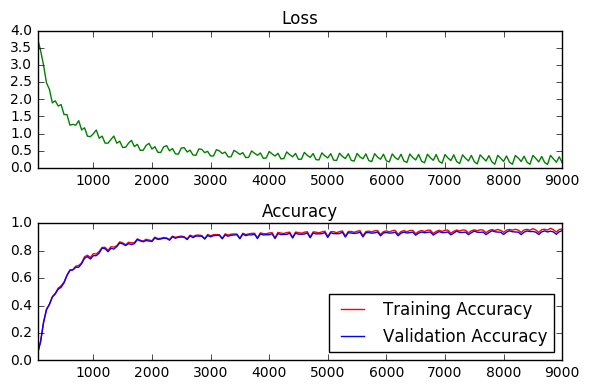

Total Time Elapsed: 1328.17 seconds


In [13]:
#Training parameters:
epochs = 30
batch_size = 128

saver = tf.train.Saver()
start = time.clock()

#Empty arrays to collect and plot loss and accuracy batch data from Training Cycle:
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    
    #Initialize all variables to use them in TensorFlow:
    session.run(tf.initialize_all_variables())
    
    #Calculate the total number of batches needed:
    batch_count = int(math.ceil(len(X_train)/batch_size))

    for epoch_i in range(epochs):
        #Set up and run the training cycle:
        for batch_i in range(batch_count):
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = X_train[batch_start:batch_start + batch_size]
            batch_labels = y_train[batch_start:batch_start + batch_size]

            #Run optimizer in TensorFlow session to get loss value.
            _, l = session.run([optimizer, loss],
                               feed_dict={features: batch_features, labels: batch_labels})
        
        #Store every 50th batch's data in an array to use for visualization:
            if not batch_i % 50:
                #Calculate accuracy of the training and validation sets:
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                #Create arrays for plotting loss and accuracy graphs:
                previous_batch = batches[-1] if batches else 0
                batches.append(50 + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)
        
        if epoch_i % 5 == 4:
            print('Epoch: {:>2f}/{:>2f} | Accuracy: {:^.2f}% | Time Elapsed: {:^2f}'.format(epoch_i+1, epochs, validation_accuracy * 100, (time.clock() - start)))
    
    test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)
    
    # Save checkoint
    save_path = saver.save(session, "model.ckpt")
    print("Model saved in file: {}".format(save_path))
    
print('Training Accuracy: {:^.2f}'.format(training_accuracy * 100))
print('Validation Accuracy: {:^.2f}'.format(validation_accuracy))
print('Test Accuracy: {:^.2f}'.format(test_accuracy))

plot_loss_accuracy(batches, loss_batch, train_acc_batch, valid_acc_batch)

end = time.clock()
print('Total Time Elapsed: {:>.2f} seconds'.format(end - start))

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** 

<span style="color: red"> After some serious investigation on the forums, I decided to use a batch size of 128 and a hidden layer weight equal to the size of the input images, in my case 3072 (32x32x3, since I didn't end up using my grayscale function). I found that 30 traning epochs gave me decent accuracy for the time it took to run the code, and I went with the Adam Optimizer because it performed better than the plain SGD optimizer. </span>

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

<span style="color: red"> Initially I chose to implement a ConvNet that was similar to the one discussed in the lessons. However, as I worked on my implementation I realized that with the limited RAM on my CPU the code I had was taking too long to run and would often crash the kernel. As a result, I experimented with the TensorFlow example deep neural network from the lessons and found that I was able to get decent performance with a simpler network. In the future, I could improve this pipeline by converting my network to a ConvNet and running everything through a GPU or an AWS instance of a GPU. </span>

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

<span style="color: red"> The candidate images I have chosen are displayed below. I attempted to find images that would be similar to the German Traffic Signs Data. Particularly the RGBA format of these images was the hardest part to pre-process. Once I realized that removing the alpha channel of each image was necessary, I tweaked my pre-processing with grayscale and RGB approaches and ultimately chose to leave the images in RGB format to run the predictions. </span>

Candidate Images:


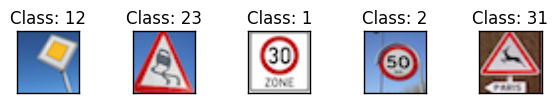

In [14]:
filenames = [
    'priority_road.png',
    'slippery_road.png',
    'limit_30.png',
    'limit_50.png',
    'wild_animals.png']

filename_labels = [12,
                   23,
                   1,
                   2,
                   31]

images = []
for sign in filenames:
    sign = cv2.imread("signs/{}".format(sign))
    sign = normalize(sign.astype(np.float32))
    sign = sign.reshape(np.prod(sign.shape))
    images.append(sign)

label_names = {}

with open('signnames.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for (label, name) in reader:
        label_names[label] = name
        
def label_text(label):
    label = str(label)
    return label_names[label]

def addsubplot(i, feature):
    plt.subplot(1,5,i)
    plt.xticks(()); plt.yticks(());
    plt.tight_layout(pad=2.5, w_pad=3.0, h_pad=1.0)
    plt.title('Class: {}'.format(filename_labels[i-1]))
    plt.imshow(feature)

print('Candidate Images:')
n = 0
for image in filenames:
    image = mpimg.imread('signs/' + image)
    plt.figure(1)
    addsubplot(n+1, image)
    n +=1

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:** 

<span style="color: red"> As shown below, my model was not able to correctly classify any of the candidate images. The combination of the small sample size of five images and the simplicity of my neural network did not allow room for success. </span>

<span style="color: red"> From the predictions I ran on the candidate images, the testing accuracy is 0%, however my model's accuracy on the traning set was 84%. As a result, my model did not perform well in the real-world cases. I believe that the biggest reason for this is the small sample size of only 5 candidate images. My network architecture is also very simple, so there is enough room for error that makes inaccurate predictions fairy commonplace. As shown below, a small consolation is that one of the images has the correct classification in the top five of its K values, proving that further tweaking of the model should improve my real-world performance.</span>

<span style="color: red"> I did not test the model on a live camera stream. </span>

In [15]:
saver = tf.train.Saver()

with tf.Session() as session:
    saver.restore(session, "model.ckpt")
    print("Model restored from previous training cycle.")
    print("")
    
    prediction_op = tf.argmax(logits, 1)
    predictions = session.run(prediction_op, feed_dict={features: images})
    
    print("{:20}{:8}{:20}".format("FILENAME:", "LABEL:", "PREDICTION:"))
    for i, prediction in enumerate(predictions):
        print("{:20}{:<8}{:20}".format(filenames[i], prediction, label_text(prediction)))

Model restored from previous training cycle.

FILENAME:           LABEL:  PREDICTION:         
priority_road.png   3       Speed limit (60km/h)
slippery_road.png   12      Priority road       
limit_30.png        35      Ahead only          
limit_50.png        35      Ahead only          
wild_animals.png    4       Speed limit (70km/h)


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:** 

<span style="color: red"> Unfortunately, my model was not able to correctly classify any of the candidate images. For the first image, priority_road.png, the correct prediction was in the top five k's, so I believe that with further adjustments I could potentially classify each image correctly. </span>

Model restored from previous training cycle.

Validation Accuracy: 0.95%
Test Accuracy: 0.84%
Candidate Images Accuracy: 0.00%


Predicted (3) Speed limit (60km/h), Actual (12) priority_road.png


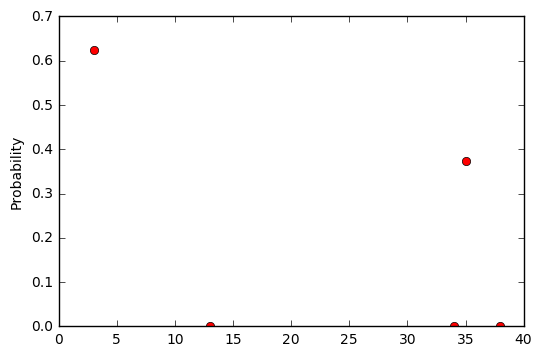


Predicted (12) Priority road, Actual (23) slippery_road.png


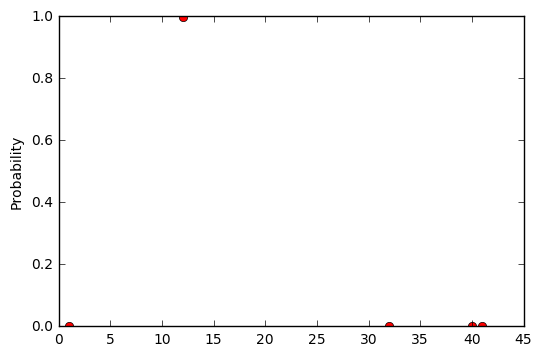


Predicted (35) Ahead only, Actual (1) limit_30.png


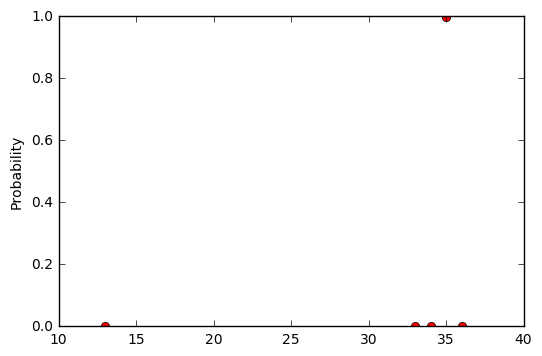


Predicted (35) Ahead only, Actual (2) limit_50.png


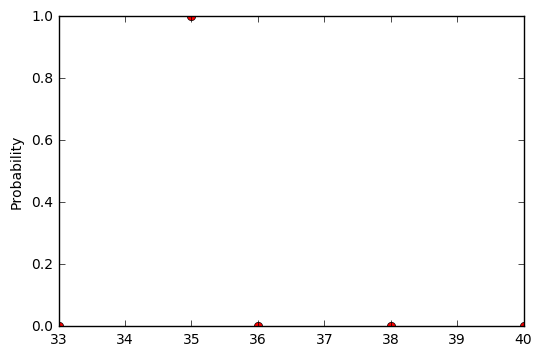


Predicted (4) Speed limit (70km/h), Actual (31) wild_animals.png


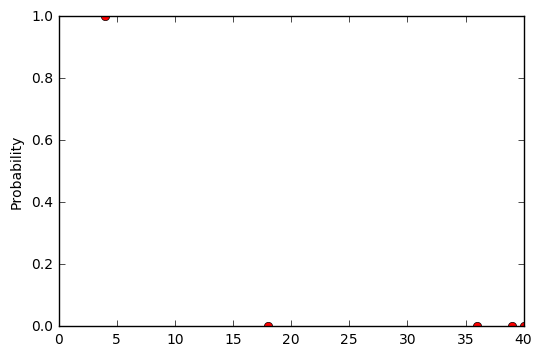

In [16]:
def plot_top_k_probabilities(labels, probabilities, title):
    print(title)
    plt.plot(list(labels), list(probabilities), 'ro')
    plt.ylabel('Probability') 
    plt.show()

encoder = LabelBinarizer()
encoder.fit(y_train)
encoded_labels = encoder.transform(filename_labels)

saver = tf.train.Saver()

with tf.Session() as session:
    saver.restore(session, "model.ckpt")
    print("Model restored from previous training cycle.")
    print("")
    
    prediction_op = tf.nn.softmax(logits)
    top_five = tf.nn.top_k(prediction_op, k=5, sorted=True, name=None)
    predictions, acc = session.run([top_five, accuracy], feed_dict={features: images, labels: encoded_labels})
    prediction_values, prediction_indices = predictions
    
    print('Validation Accuracy: {:.2f}%'.format(validation_accuracy))
    print('Test Accuracy: {:.2f}%'.format(test_accuracy))
    print('Candidate Images Accuracy: {:.2f}%'.format(acc))
    print("")
    
    for i, (probabilities, labels) in enumerate(zip(prediction_values, prediction_indices)):
        title = "Predicted ({}) {}, Actual ({}) {}".format(labels[0], label_text(labels[0]), filename_labels[i], filenames[i])
        print("")
        plot_top_k_probabilities(labels, probabilities, title)

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:** 

<span style="color: red"> N/A </span>

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.